# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from copy import deepcopy

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.wandb_utils.zip_handler_simba import SimbaZipHandler
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    compute_thresholds_per_env,
)
from scripts.constants import DEFAULT_MAX_STEPS, BASE_THRESHOLDS

from scripts.core.bootstrapping import (
    grid_best_uncertainty_bs,
    plot_optimal_hparam_fit_per_env_utd_pretty,
    plot_optimal_hparam_fit_per_env_n_pretty,
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_inverse_power_product_log_normalize,
    predict_inverse_power_product_log_normalize,
)


from scripts.experiments.utd_x_width_x_bs import plot_utils


import qscaled

qscaled.constants.QSCALED_PATH = os.path.expanduser('~/.value-scaling')
qscaled.constants.suppress_overwrite_prompt = True

In [3]:
ModelSizeSweepConfig = BaseConfig

config_input_dict = dict(
    zip_handler_cls=SimbaZipHandler,
    max_returns={},
    returns_key='return',
    thresholds=[],
)

config = ModelSizeSweepConfig(
    name='simbav2_model_scaling',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

In [4]:
def linear_threshold_with_base(env, max_thresh):
    return np.linspace(BASE_THRESHOLDS[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

config.name += threshold_description

In [5]:
df = fetch_zip_data(config, use_cached=True)

In [6]:
THRESHOLD_COMPUTE_METHOD = 'worst'


def preprocess(df, config, use_cached, query=None, max_threshold_per_env=None):
    df = deepcopy(df)
    df = df.loc[df['training_step'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 1)]

    # Phase 1: Determine thresholds with a good subset of runs
    if max_threshold_per_env is None:
        complete_runs = df
        fill_isotonic_regression(
            complete_runs,
            training_step_key='training_step',
            mean_return_key='mean_avg_return',
        )
        max_threshold_per_env = compute_thresholds_per_env(
            complete_runs, mode=THRESHOLD_COMPUTE_METHOD
        ).to_dict()

    # Phase 2
    fill_isotonic_regression(
        df,
        training_step_key='training_step',
        mean_return_key='mean_avg_return',
    )

    # Postprocessing
    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step',
        return_key='avg_return',
        filename=f'{config.name}_{THRESHOLD_COMPUTE_METHOD}',
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['avg_return'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['avg_return'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )

    for c in df:
        if 'std' in c:
            df[c] /= np.sqrt(5)  # there are actually 5 seeds per job

    df['learning_rate'] = 1e-4
    return df, max_threshold_per_env, thresholds_per_env


# copied from scaling_laws.ipynb
max_threshold_per_env = {
    'h1-crawl-v0': 788.8871690886515,
    'h1-pole-v0': 811.2782557242151,
    'h1-stand-v0': 657.0001967485866,
    'humanoid-stand': 858.6898385806944,
}

SIMBA_MODEL_SIZES = {
    128: 604362,
    256: 2322634,
    512: 9101514,
    1024: 36028618,
    2048: 143360202,
}
df['critic_params'] = df['critic_width'].map(SIMBA_MODEL_SIZES).astype(int)

df, _, thresholds_per_env = preprocess(
    df,
    config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

Average standard deviation across all conditions: 41597.47


In [7]:
max_threshold_per_env

{'h1-crawl-v0': 788.8871690886515,
 'h1-pole-v0': 811.2782557242151,
 'h1-stand-v0': 657.0001967485866,
 'humanoid-stand': 858.6898385806944}

# Learning curves

{'h1-crawl-v0': <Figure size 1200x1250 with 20 Axes>,
 'h1-stand-v0': <Figure size 1200x1250 with 20 Axes>}

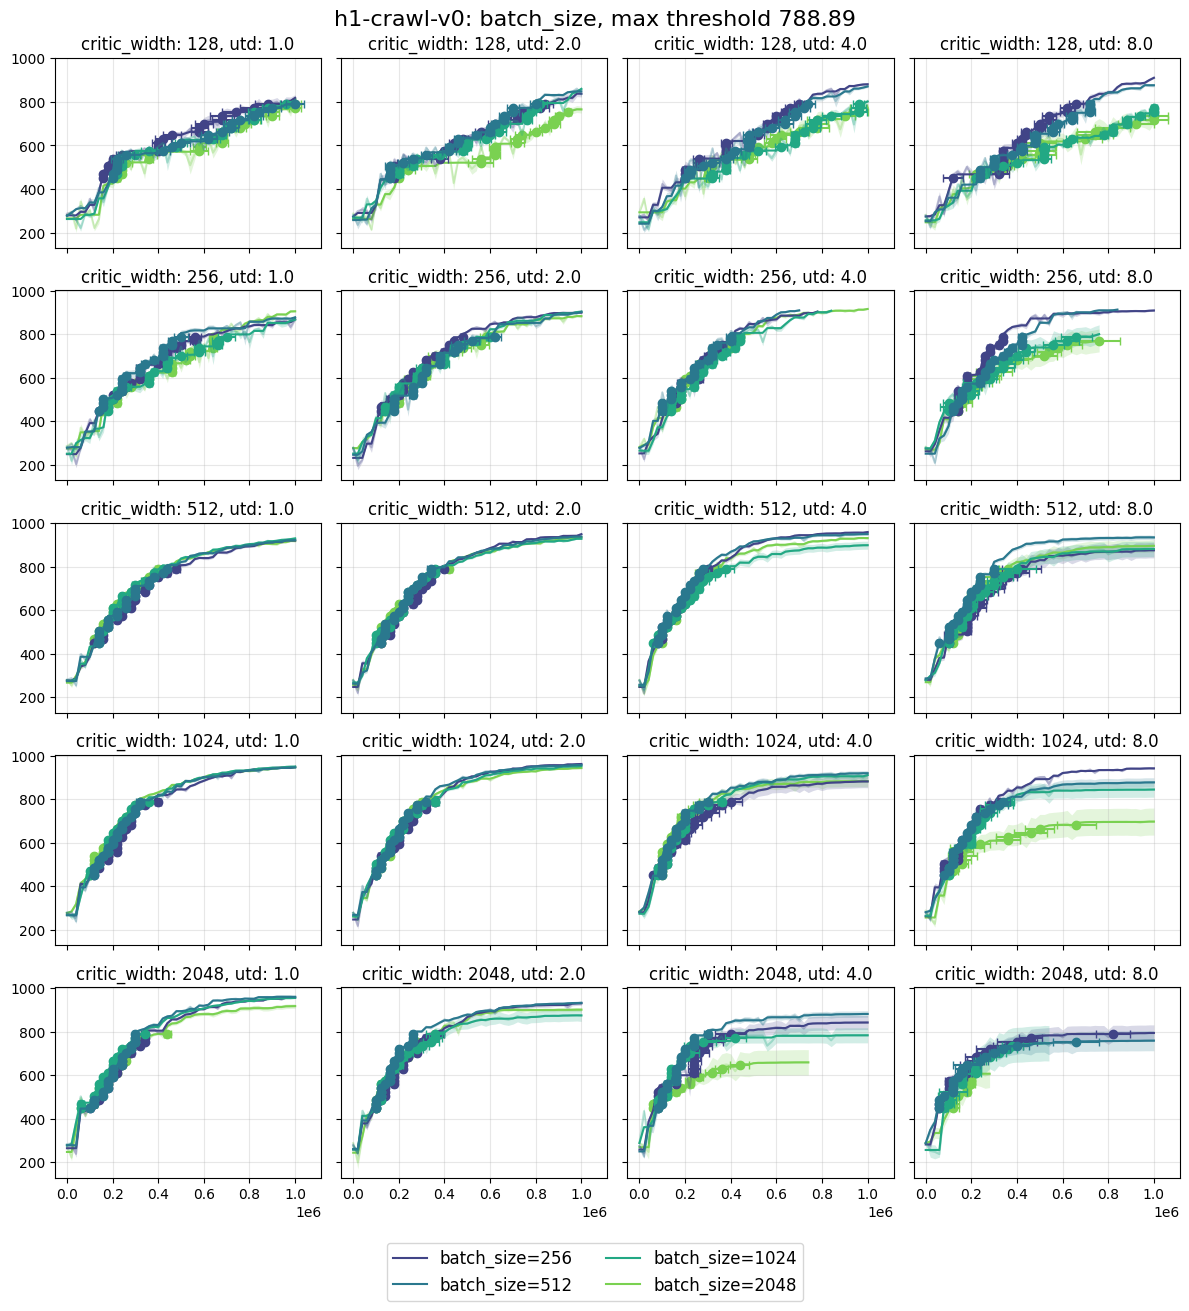

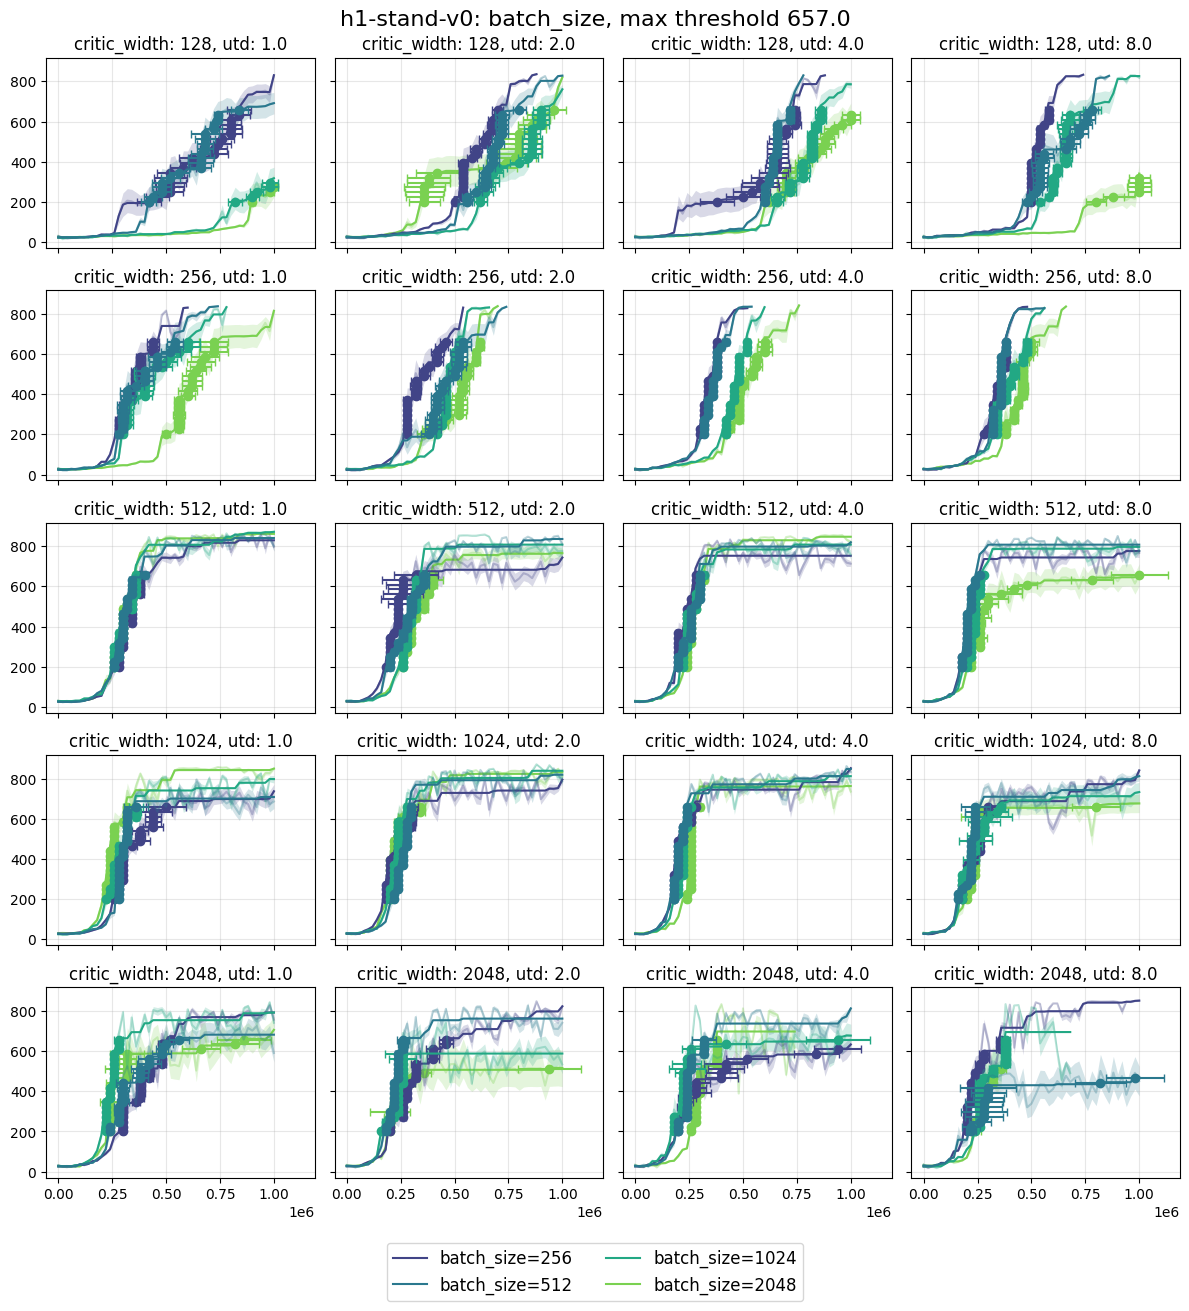

In [8]:
plot_utils.plot_learning_curves_with_thresholds(
    df,
    'batch_size',
    thresholds=thresholds_per_env,
    row_attr_name='critic_width',
    col_attr_name='utd',
    mean_return_key='mean_avg_return',
    std_return_key='std_avg_return',
    return_isotonic_key='return_isotonic',
    hline=False,
)

# Figure 12: Bootstrapped optimal batch size

In [9]:
def assign_batch_size_uncertainty(df, threshold_idx=-1, goodness_criteria='overlap'):
    complete_sweep = df.groupby(['env_name', 'critic_width', 'utd'])['batch_size'].count()
    valid_groups = complete_sweep[complete_sweep >= 3].index
    complete_sweep_df = (
        df.set_index(['env_name', 'critic_width', 'utd']).loc[valid_groups].reset_index()
    )
    best_bs = grid_best_uncertainty_bs(
        complete_sweep_df, threshold_idx, goodness_criteria=goodness_criteria
    )
    best_bs['good_enough_bs_ratio'] = (
        best_bs['largest_bs_good_enough'] / best_bs['smallest_bs_good_enough']
    )
    return best_bs


best_bs_key = 'best_bs_bootstrap_mean'
best_bs = assign_batch_size_uncertainty(df, goodness_criteria='overlap')

df_with_best_bs_subset = pd.merge(
    df,
    best_bs,
    left_on=['env_name', 'critic_width', 'critic_params', 'utd', 'batch_size', 'learning_rate'],
    right_on=['env_name', 'critic_width', 'critic_params', 'utd', 'best_bs', 'learning_rate'],
)

In [10]:
xcols = ['utd', 'critic_params']

best_bs_with_fit, params_dict_product = insert_predictions_inverse_power_product_log_normalize(
    df_with_best_bs_subset,
    xcols,
    best_bs_key,
    name=config.name,
    use_cached=True,
    log_loss=True,
)

predict_inverse_power_product_log_normalize_ = (
    lambda df: predict_inverse_power_product_log_normalize(df, xcols, params_dict_product)
)

upward_asymptotes_product = {
    (k, utd): params[0] / utd ** params[3]
    for k, params in params_dict_product.items()
    for utd in df['utd'].unique()
}

upward_asymptotes_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'b': params[1],
            'c': params[2],
            'alpha': params[3],
            'a_unscaled': params[4],
            'b_unscaled': params[5],
            'c_unscaled': params[6],
        }
        for k, params in params_dict_product.items()
    ]
)

Loaded params from /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/simbav2_model_scaling_linear20_with_base/utd_critic_params_best_bs_bootstrap_mean_inverse_power_product.npy


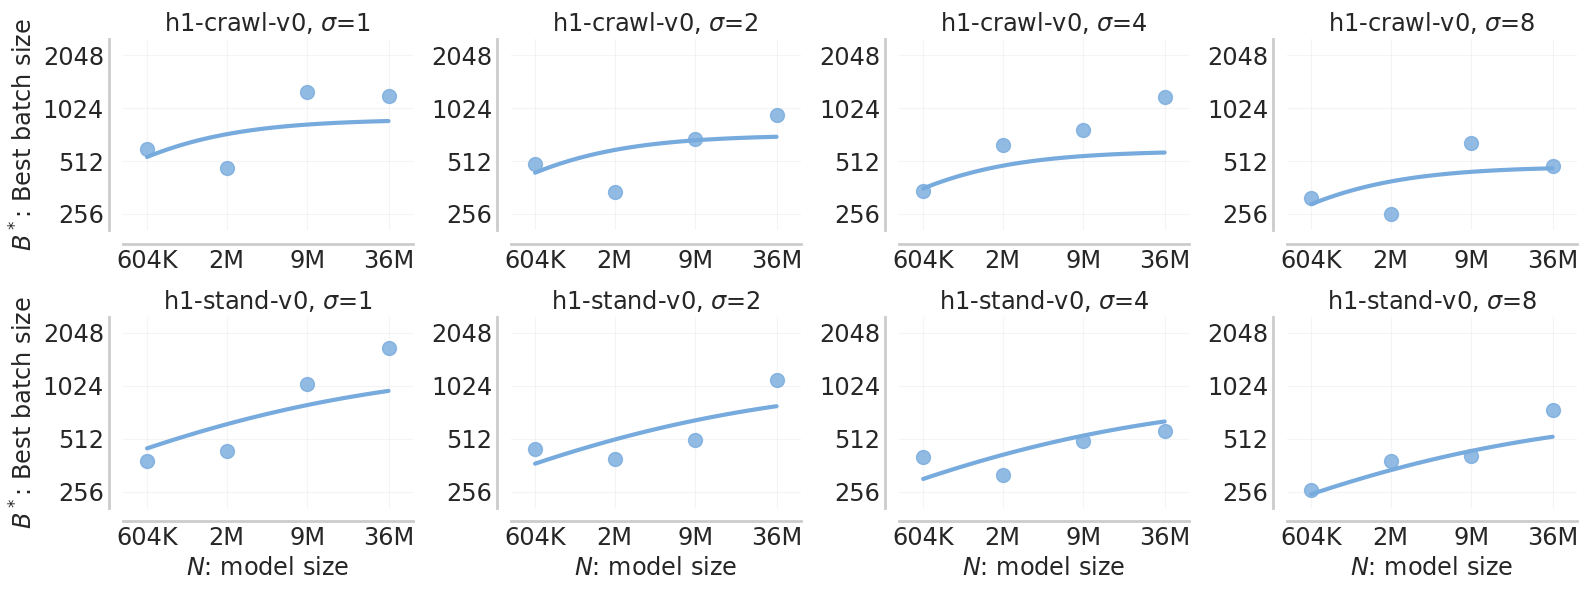

In [14]:
plot_optimal_hparam_fit_per_env_utd_pretty(
    best_bs_with_fit.query('critic_width<2048'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {'color': 'qscaled_1', 'label': '$B^*(\sigma)$'},
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
    inner_axis_label=False,
    set_ylim=False,
    yticks=[256, 512, 1024, 2048],
)

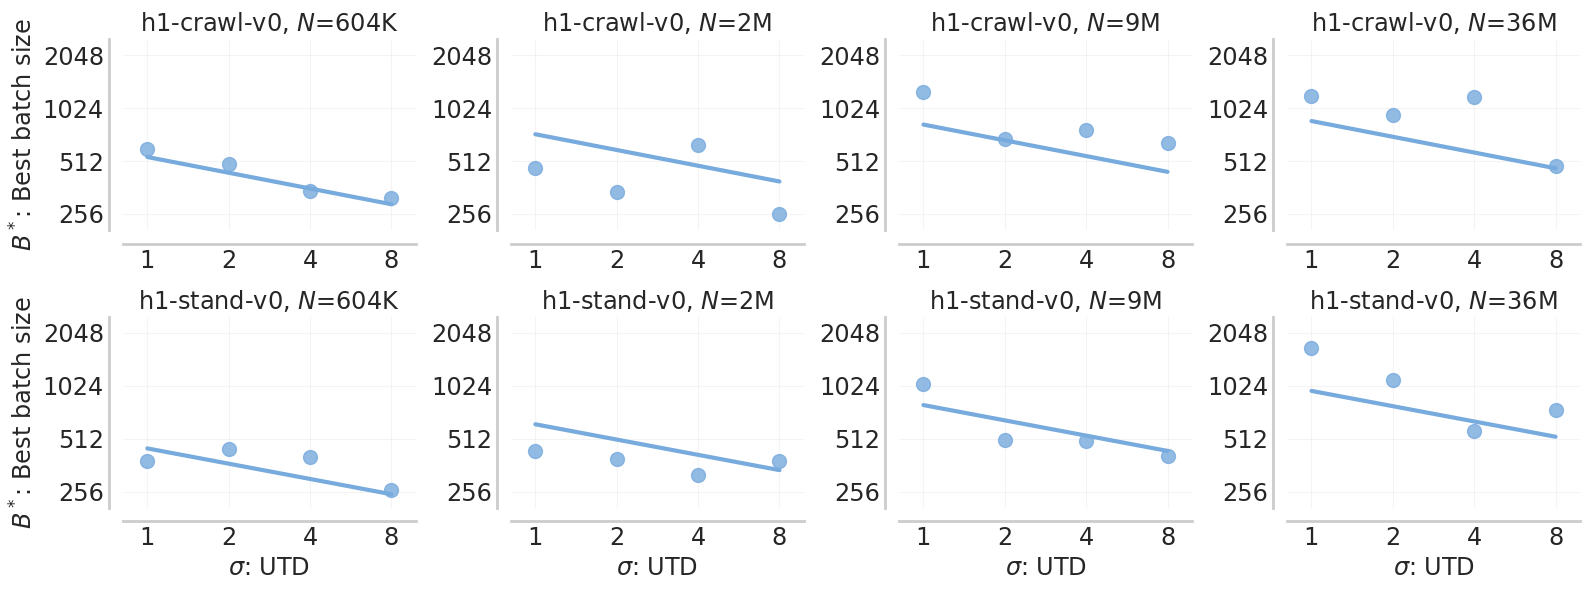

In [15]:
plot_optimal_hparam_fit_per_env_n_pretty(
    best_bs_with_fit.query('critic_width<2048'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {'color': 'qscaled_1', 'label': '$B^*(\sigma)$'},
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
    inner_axis_label=False,
    set_ylim=False,
    yticks=[256, 512, 1024, 2048],
)

# Data efficiency fits

In [16]:
best_bs_df_for_data_fits = best_bs_with_fit.query('critic_width<2048')
best_bs_df_for_data_fits['time_to_threshold_std'] = best_bs_df_for_data_fits[
    'time_to_threshold_bootstrap'
].apply(lambda x: np.nanstd(x[x < np.inf], ddof=0))

In [17]:
best_bs_df_for_data_fits, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
    best_bs_df_for_data_fits,
    xcols,
    'time_to_threshold',
    name=config.name,
    use_cached=False,
    log_loss=True,
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

data_efficiency_sum_powerlaw_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for utd in set(df['utd'].unique())
}

data_efficiency_sum_powerlaw_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for n in set(df['critic_params'].unique())
}

data_efficiency_sum_powerlaw_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_params.items()
    ]
)

Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/simbav2_model_scaling_linear20_with_base/utd_critic_params_time_to_threshold_sum_powerlaw.npy


## Subset of Figure 6

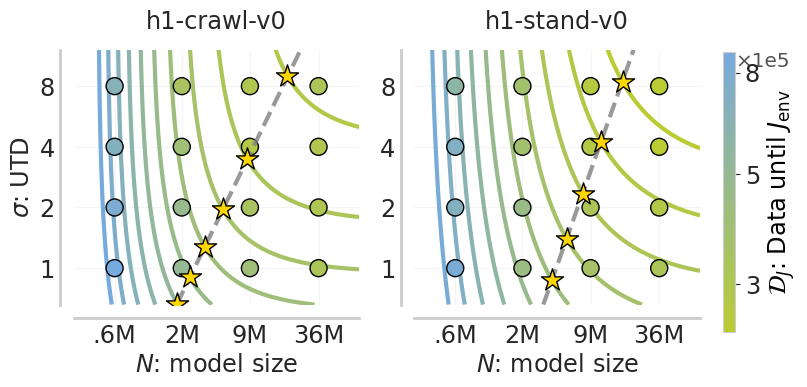

In [18]:
_ = plot_utils.plot_optimal_hparams_scatter_pretty(
    df=best_bs_df_for_data_fits,
    predict_fn=predict_data_efficiency_sum_powerlaw_,
    data_efficiency_key='time_to_threshold',
    mode='data_contour',
    show_optima_as_stars=True,
    show_cost_contour=False,
    params=time_to_thresh_sum_powerlaw_params,
    cbar_ticks=[3e5, 5e5, 8e5],
    cbar_scale='1e5',
)

In [19]:
save_df = (
    best_bs_df_for_data_fits[
        [
            'env_name',
            'utd',
            'critic_width',
            'critic_params',
            'time_to_threshold',
            'time_to_threshold_std',
            'time_to_threshold_sum_powerlaw',
        ]
    ]
    .query('critic_width<2048')
    .sort_values(by=['env_name', 'utd', 'critic_params'])
    .reset_index(drop=True)
)

save_df.to_csv('../saved_fits/simba_250823.csv', index=False)